In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
import argparse
from scutils import best_response
from scutils import SC_solver, OperatorSC
import scipy.linalg  as sla
from cf_matrix import make_confusion_matrix as mkcfmat
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import seaborn as sns

%load_ext autoreload
%autoreload 2

## Strategic Prediction Under Competition

Consider the following feature generation process:
$$z_1|\theta=g(\theta)+A_1x_1+A_{-1}x_2+w_1$$
and
$$z_2|\theta=g(\theta)+A_2x_2+A_{-2}x_1+w_2$$
where $\beta\sim \mathcal{D}_{\theta}=\mathcal{N}(0,\sigma_\theta^2 I)$ and $w_i\sim \mathcal{N}(0,\sigma_i^2 I)$. For simplicity we take $$g(\theta)= \theta^\top B, \quad B\in \mathbb{R}^{d\times 1}, \ \theta\in \mathbb{R}^{m\times d}$$ 

Each player $i$ seeks to minimize the following loss
$$\frac{1}{2}(z_i-\theta^\top x_i)^2$$

Hence, 
$$\nabla_iL_i=\mathbb{E}_{w_i,\theta}[(A_i-\theta^\top)^\top(z_i-\theta^\top x_i)]=\mathbb{E}_{w_i,\theta}[(A_i-\theta^\top)^\top(\theta^\top B+A_ix_i+A_{-i}x_{-i}+w_i-\theta^\top x_i)]$$
and the Hessian is 
$$\nabla_i^2L_i=\mathbb{E}_{w_i,\theta}[(A_i-\theta^\top)^\top (A_i-\theta^\top)]$$

In [82]:
N=1000
N_test=100
MAXITER=100
sigma_theta=0.01
sigma_w=0.01
m=2 # both players dimension of z_i
d=2
B=np.array([[1],[1]]) #np.random.rand(d,1)
np.random.seed(2)
A1=np.array([[1,0],[0,1]]) #np.random.rand(m,d)
Am1=np.array([[0.1,0],[0,0.0]]) #np.random.rand(m,d)
A2=np.array([[1.0,0],[-0, 1]]) #np.random.rand(m,d)
Am2=np.array([[0,0],[0, 0.1]])#np.random.rand(m,d)

l=[-5,-5]
u=[5,5]

D_theta=lambda _: np.random.normal(0,sigma_theta,size=(d,m))

def D_w(player):
    if player==0:
        return np.random.normal(2,sigma_w,size=(m,))
    else:
        return np.random.normal(1,sigma_w,size=(m,))

n=2
def proj(x, l=l, u=u):
    y=np.zeros(np.shape(x))
    for i in range(n):
        for j in range(d):
            if x[i][j]<=l[j]:
                y[i][j]=l[j]
            elif l[j]<x[i][j] and x[i][j]<u[j]:
                y[i][j]=x[i][j]
            else:
                y[i][j]=u[j]
    return y

def getgrad(x,theta):
    w=D_w(0)
    p1=(A1-theta.T).T@(theta.T@B.flatten()+A1@x[0]+Am1@x[1]+w-theta.T@x[0])
    #print(np.shape(p1))
    w=D_w(1)
    p2=(A2-theta.T).T@(theta.T@B.flatten()+A2@x[1]+Am2@x[0]+w-theta.T@x[1])
    #print(np.shape(p2))
    return np.vstack((p1.T,p2.T))

def getHess(x,th):
    H1=(A1-th.T).T@(A1-th.T)
    H2=(A2-th.T).T@(A2-th.T)
    return H1,H2



In [86]:

MAXITER=100000
#D_theta(_)`
print()
_,S1,_=la.svd(A1)
_,S2,_=la.svd(A2)
S1=np.sort(S1)[-1]
S2=np.sort(S2)[-1]
eta=0.0001 #1/np.max([S1,S2])
print(eta)
x0=np.random.rand(2,d)
x=[x0]
for i in range(MAXITER):
    th=np.random.normal(0,sigma_theta,size=(d,m))
    #print(getgrad(x[-1],th))
    x.append(proj(x[-1]-eta*getgrad(x[-1],th)))
    
H1,H2=getHess(x[-1],th)
print(H1)
print(H2)
print("eigs p1 :", la.eigvals(H1))
print("eigs p2 :", la.eigvals(H2))


0.0001
[[0.99716668 0.00844373]
 [0.00844373 1.00360492]]
[[0.99716668 0.00844373]
 [0.00844373 1.00360492]]
eigs p1 : [0.99134924 1.00942235]
eigs p2 : [0.99134924 1.00942235]


In [87]:
getgrad(x[-1],th)

array([[ 0.00535612, -0.03546055],
       [ 0.01372193, -0.02291241]])

(100001, 2, 2)


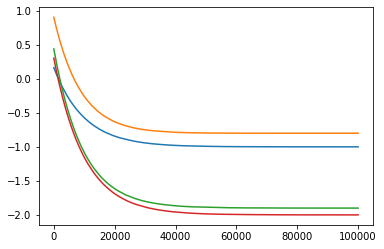

In [88]:
x=np.asarray(x)
print(np.shape(x))
plt.plot(x[:,1])
plt.plot(x[:,0])

## Strategic Revenue Maximization Under Competition

Consider the following feature generation process:
$$z_1=z_{1,0}+A_1x_1+A_{-1}x_2, \ \ z_{1,0}\sim \mathcal{D}_{1,0}$$
and
$$z_2=z_{2,0}+A_2x_2+A_{-2}x_1, \ \ z_{2,0}\sim \mathcal{D}_{2,0}$$
where $\mathcal{D}_{i,0}=\mathcal{N}(0,\sigma_i^2 I)$. 

Each player $i$ seeks to minimize the following loss
$$-\frac{1}{2}z_i^\top x_i +\frac{\lambda}{2}\|x_i\|^2=-\frac{1}{2}(z_{i,0}+A_ix_i+A_{-i}x_{-i})^\top x_i +\frac{\lambda}{2}\|x_i\|^2$$
where $0<A_i\in \mathbb{R}^{d_i\times d_i}$ and $0>A_{-i}\in \mathbb{R}^{d_i\times d_{-i}}$ representing negative price elasticity to your own pricing chagnes and positive price elasticity to your competitors.

Hence, 
$$\nabla_iL_i=\mathbb{E}_{w_i,\theta}[-(A_i-\lambda I) x_i -\frac{1}{2} A_{-i}x_{-i}]$$
and the Hessian is 
$$\nabla_i^2L_i=\mathbb{E}_{w_i,\theta}[-(A_i^\top-\lambda I)]$$

In [397]:
N=1000
N_test=100
MAXITER=100
sigma_theta=0.01
sigma_z1=0.0001
sigma_z2=0.0001
lam1=0.0; lam2=0.0
m=1 # both players dimension of z_i
d=2
maxx=10
maxy=10
l=[-maxx,-maxx]
u=[maxx,maxx]
n=2 # num players
I=np.eye(d)
seed=2
np.random.seed(seed)

def D_z(player):
    if player==0:
        return np.random.normal(10,sigma_z1,size=(m,1))
    else:
        return np.random.normal(5,sigma_z2,size=(m,1))


A1=np.array([[-1,0.1],
             [0.1,-1]]) #np.random.rand(m,d)
Am1=np.array([[0.5,0],
              [0,0.5]]) #np.random.rand(m,d)
A2=np.array([[-1, 0],
             [0,-1]]) #np.random.rand(m,d)
Am2=np.array([[0.5, 0],
              [0,0.5]])#np.random.rand(m,d)


def proj(x, l=l, u=u):
    y=np.zeros(np.shape(x))
    for i in range(n):
        for j in range(d):
            if x[i][j]<=l[j]:
                y[i][j]=l[j]
            elif l[j]<x[i][j] and x[i][j]<u[j]:
                y[i][j]=x[i][j]
            else:
                y[i][j]=u[j]
    return y

def getgrad(x,z1_,z2_, perform=[True,True]):
    if np.all(perform):
        p1=-(A1-lam1*I).T@x[0]-1/2*(z1_+Am1@x[1])
        p2=-(A2-lam1*I).T@x[1]-1/2*(z2_+Am2@x[0])
    else:
        if perform[0]:
            p1=-(A1-lam1*I).T@x[0]-1/2*(z1_+Am1@x[1])
        else: 
            p1=-(A1-lam1*I).T@x[0]-1/2*(z1_)
        if perform[1]:
            p2=-(A2-lam1*I).T@x[1]-1/2*(z2_+Am2@x[0])
        else:
            p2=-(A2-lam1*I).T@x[1]-1/2*(z2_)
    return np.vstack((p1,p2))

def getHess(x):
    H1=-(A1.T-lam1*I)
    H2=-(A2.T-lam2*I)
    return H1,H2

def query_env(x,perform=[True,True]):
    '''
       if perform=true:
          return environment query with the performative effects
    '''
    z1_=D_z(0)
    z2_=D_z(1)
    if perform[0]:
        z1=z1_+A1@x[0]+Am1@x[1]
    else:
        z1=z1_+A1@x[0]
    if perform[1]:
        z2=z2_+A2@x[1]+Am2@x[0]
    else:
        z2=z2_+A2@x[1]
    return z1,z2

def query_env_player(x, player, A=A1,A_=Am1):
    '''
       if perform=true:
          return environment query with the performative effects
    '''
    z_=D_z(player)
    if player==0:
        z=z_+A@x[0]+A_@x[1]
    if player==1:
        z=z_+A@x[1]+A_@x[0]
    return z

def loss(x,player, A=A1,A_=Am1):
    z=query_env_player(x, player, A=A,A_=A_)
    #print("shape of z: ", np.shape(z))
    return -0.5*z@x[player]+lam1*la.norm(x[player])

def revenue(x,player, A=A1,A_=Am1):
    z=query_env_player(x, player, A=A,A_=A_)
    #print("shape of z: ", np.shape(z))
    return 0.5*z@x[player]

In [398]:

MAXITER=10000
#D_theta(_)`
print()
_,S1,_=la.svd(A1)
_,S2,_=la.svd(A2)
S1=np.sort(S1)[-1]
S2=np.sort(S2)[-1]
eta=0.001 #1/np.max([S1,S2])
print(eta)
x0=np.random.rand(2,d)
x_comp=[x0]; perform_comp=[True,True]
x_p1_ignore=[x0]; perform_p1_ignore=[False,False]
rev_comp_p1=[revenue(x_comp[-1],0,A=A1,A_=Am1)]
rev_comp_p2=[revenue(x_comp[-1],1,A=A2,A_=Am2)]
rev_ig_p1=[revenue(x_p1_ignore[-1],0,A=A1,A_=Am1)]
rev_ig_p2=[revenue(x_p1_ignore[-1],1,A=A2,A_=Am2)]
for i in range(MAXITER):
    z1_=D_z(0)
    z2_=D_z(1)
    x_comp.append(proj(x_comp[-1]-eta*getgrad(x_comp[-1],z1_,z2_,perform=perform_comp)))
    rev_comp_p1.append(revenue(x_comp[-1],0,A=A1,A_=Am1))
    rev_comp_p2.append(revenue(x_comp[-1],1,A=A2,A_=Am2))
    #print(x_comp[-1])
    x_p1_ignore.append(proj(x_p1_ignore[-1]-eta*getgrad(x_p1_ignore[-1],z1_,z2_,perform=perform_p1_ignore)))
    rev_ig_p1.append(revenue(x_p1_ignore[-1],0,A=A1,A_=Am1))
    rev_ig_p2.append(revenue(x_p1_ignore[-1],1,A=A2,A_=Am2))
H1,H2=getHess(x_comp[-1])
print("eigs p1  : ", la.eigvals(H1))
print("eigs p2  : ", la.eigvals(H2))
print("gradient : ", getgrad(x_comp[-1],z1_,z2_))
print("Revenues when P1 considers performative effects")
print("p1 revenue: \n", revenue(x_comp[-1],0,A=A1,A_=Am1))
print("p2 revenue: \n", revenue(x_comp[-1],1,A=A2,A_=Am2))
print("x_comp : \n", x_comp[-1])
print()
H1,H2=getHess(x_p1_ignore[-1])
print("eigs p1   : ", la.eigvals(H1))
print("eigs p2   : ", la.eigvals(H2))
print("gradient  : ", getgrad(x_p1_ignore[-1],z1_,z2_))
print("Revenues when P1 ignores performative effects")
print("p1 revenue: \n", revenue(x_p1_ignore[-1],0,A=A1,A_=Am1))
print("p2 revenue: \n", revenue(x_p1_ignore[-1],1,A=A2,A_=Am2))
print("x_p1_ignore: \n", x_p1_ignore[-1])


0.001
eigs p1  :  [1.1 0.9]
eigs p2  :  [1. 1.]
gradient :  [[-0.00377326 -0.00383549]
 [-0.00296162 -0.00303646]]
Revenues when P1 considers performative effects
p1 revenue: 
 [40.58492487]
p2 revenue: 
 [17.4532692]
x_comp : 
 [[6.71101568 6.71093766]
 [4.17470129 4.17460695]]

eigs p1   :  [1.1 0.9]
eigs p2   :  [1. 1.]
gradient  :  [[-0.62558437 -0.62559056]
 [-1.38872286 -1.38872633]]
Revenues when P1 ignores performative effects
p1 revenue: 
 [34.72125877]
p2 revenue: 
 [13.19369896]
x_p1_ignore: 
 [[5.55490308 5.55489627]
 [2.4999119  2.49990673]]


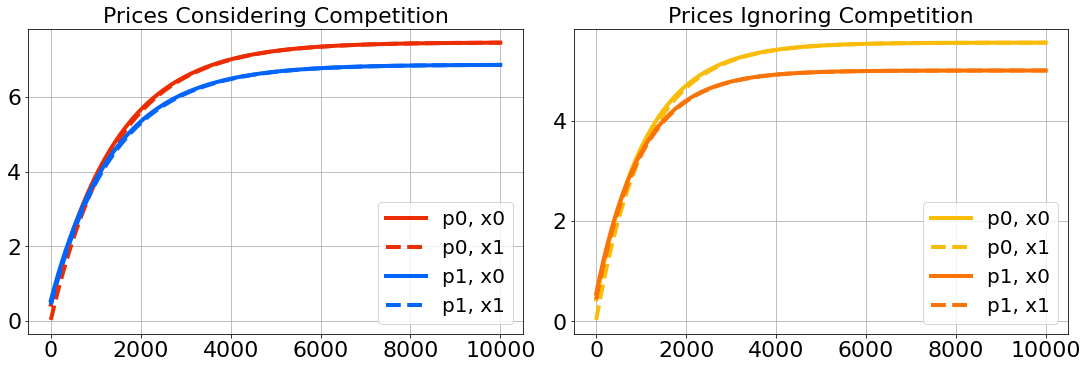

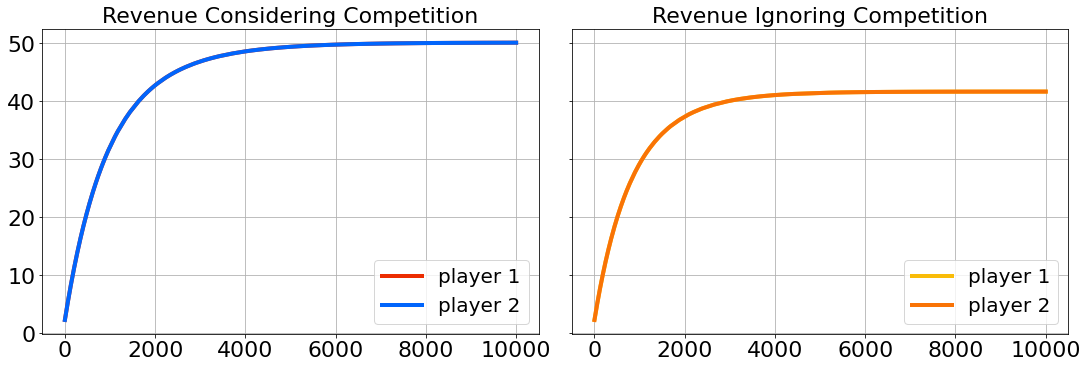

In [396]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=False)
lw=4
palette = ['xkcd:golden rod', 'xkcd:orange', 'xkcd:tomato red', 'xkcd:bright blue', 'xkcd:green', 'xkcd:purple'] 
x=np.asarray(x_comp)

for i in range(2):
    for j in range(2):
        if j==1:
            ls='--'
        else:
            ls='-'
        ax[0].plot(x[:,i,j], label='p{}, x{}'.format(i,j), color=palette[i+2], linestyle=ls, linewidth=lw)
ax[0].legend(fontsize=20)
plt.grid(True)
ax[0].grid(True)
ax[0].tick_params(labelsize=22)
ax[0].set_title('Prices Considering Competition', fontsize=22)
x=np.asarray(x_p1_ignore)

for i in range(2):
    for j in range(2):
        if j==1:
            ls='--'
        else:
            ls='-'
        ax[1].plot(x[:,i,j], label='p{}, x{}'.format(i,j), color=palette[i], linestyle=ls, linewidth=lw)
ax[1].legend(fontsize=20)
plt.grid(True)
ax[1].tick_params(labelsize=22)
ax[1].set_title('Prices Ignoring Competition', fontsize=22)
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
palette = ['xkcd:golden rod', 'xkcd:orange', 'xkcd:tomato red', 'xkcd:bright blue', 'xkcd:green', 'xkcd:purple'] 
x=np.asarray(rev_comp_p1)
y=np.asarray(rev_comp_p2)


ax[0].plot(x, label='player 1'.format(i,j), color=palette[2], linestyle='-', linewidth=lw)
ax[0].plot(x, label='player 2'.format(i,j), color=palette[3], linestyle='-', linewidth=lw)
ax[0].legend(fontsize=20)
ax[0].set_title('Revenue Considering Competition', fontsize=22)
plt.grid(True)
ax[0].grid(True)
plt.tick_params(labelsize=22)
x=np.asarray(rev_ig_p1)
y=np.asarray(rev_ig_p2)
ax[1].plot(x, label='player 1'.format(i,j), color=palette[0], linestyle='-', linewidth=lw)
ax[1].plot(x, label='player 2'.format(i,j), color=palette[1], linestyle='-', linewidth=lw)
ax[1].legend(fontsize=20)
plt.grid(True)
plt.title('Revenue Ignoring Competition', fontsize=22)
ax[0].tick_params(labelsize=22)

In [364]:
np.asarray(rev_comp_p1)

array([[ 2.27691646],
       [ 2.32542343],
       [ 2.37380056],
       ...,
       [44.43338465],
       [44.43229973],
       [44.43251745]])

## Comparing quad

Here I was going to do some loss plots to see how the parameters impact the losses.

In [ ]:
N=1000
N_test=100
MAXITER=100
sigma_theta=0.01
sigma_w=0.01
m=1 # both players dimension of z_i
d=2
B=np.array([[1],[1]]) #np.random.rand(d,1)
np.random.seed(2)
A1=np.array([[5,1]]) #np.random.rand(m,d)
Am1=np.array([[-2.5,0.3]]) #np.random.rand(m,d)
A2=np.array([[3.0, 8]]) #np.random.rand(m,d)
Am2=np.array([[-3.0, 0.1]])#np.random.rand(m,d)

l=[-5,-5]
u=[5,5]

D_theta=lambda _: np.random.normal(0,sigma_theta,size=(d,m))

def D_w(player):
    if player==0:
        return np.random.normal(0,sigma_w,size=(m,1))
    else:
        return np.random.normal(1,sigma_w,size=(m,1))


def proj(x, l=l, u=u):
    y=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]<=l[i]:
            y[i]=l[i]
        elif l[i]<x[i] and x[i]<u[i]:
            y[i]=x[i]
        else:
            y[i]=u[i]
    return y

def getgrad(x,theta):
    w=D_w(0)
    p1=(A1-theta.T).T@(theta.T@B+A1@x[0]+Am1@x[1]+w-theta.T@x[0])
    w=D_w(1)
    p2=(A2-theta.T).T@(theta.T@B+A2@x[1]+Am2@x[0]+w-theta.T@x[1])
    return np.vstack((p1.T,p2.T))

def getHess(x,th):
    H1=(A1-th.T).T@(A1-th.T)
    H2=(A2-th.T).T@(A2-th.T)
    return H1,H2

def query_env_player(x, player, A=A1,A_=Am1):
    '''
       if perform=true:
          return environment query with the performative effects
    '''
    z_=D_z(player)
    if player==0:
        z=z_+A@x[0]+A_@x[1]
    if player==1:
        z=z_+A@x[1]+A_@x[0]
    return z

def loss(x,player, A=A1,A_=Am1):
    z=query_env_player(x, player, A=A,A_=A_)
    print("shape of z: ", np.shape(z))
    return -0.5*z@x[player]+lam1*la.norm(x[player])